<a href="https://colab.research.google.com/github/dolmaenghee/team_D/blob/main/Week3_PBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

#필요한 모듈 import. 꼭 필요한 모듈만은 아닙니다.

In [19]:
#colab mount
from google.colab import drive
drive = drive.mount('/content/drive')

#현재 위치로 디렉토리 이동. 이 colab file이 있는 곳으로 작업환경을 옮깁니다. 꼭 필요한 작업은 아니나. 매번 전역경로 설정이 귀찮아서 이렇게 진행합니다.

%cd /content/drive/MyDrive/Colab Notebooks/lim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/lim


In [32]:
import time
# 두 방식 비교용 decorator
def time_taken(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken by {func.__name__}: {elapsed_time:.4f} seconds")
        return result
    return wrapper

- 교수님 께서 주신 코드 두 개. 두 방식을 비교해봅시다.

1.   METHOD I
2.   METHOD II



In [33]:
from io import BytesIO
from PIL import Image # Bytes 로 압축된 이미지를 이미지로 변환하기 위해 필요
from zipfile import ZipFile # 압축된 데이터 파일 핸들링을 위한 라이브러리

@time_taken
def extract_img_zipfile(zip_path, img_name):
    """
    zip_path: zip 파일 경로 ex) './train.zip'
    img_name: zip 파일 내 이미지 파일 이름 ex) 'train/image_0.png' or ['train/image_0.png', 'train/image_1.png', ..]
    """
    with ZipFile(zip_path, 'r') as img_file:
        # zip_path 경로 내 img_name 데이터를 읽는 코드
        img_data = img_file.read(img_name)

    # io.BytesIO 로 Byte 객체 생성
    img_bytes_io = BytesIO(img_data)

    # 생성된 Byte 객체를 ndarray 로 변환하는 코드
    with Image.open(img_bytes_io) as img:
        return np.array(img)


In [34]:
from cv2 import imdecode # opencv 미설치시 !pip install opencv-python 명령문으로 설치
import cv2

@time_taken
def extract_img_zipfile_opencv(zip_path, img_name):
    """
    zip_path: zip 파일 경로 ex) './train.zip'
    img_name: zip 파일 내 이미지 파일 이름 ex) 'train/image_0.png' or ['train/image_0.png', 'train/image_1.png', ..]
    """
    with ZipFile(zip_path, 'r') as img_file:
        # zip_path 경로 내 img_name 데이터를 읽는 코드
        img_data = img_file.read(img_name)

    # memory buffer 를 1D-ndarray 로 변환
    np_buffer = np.frombuffer(img_data, np.uint8)
    # buffer 를 gray scale image 인 2D-ndarray 로 변환
    img = imdecode(np_buffer, cv2.IMREAD_GRAYSCALE)
    return img

## IDEA FLOW

- 교수님이 주신 코드를 사용하기 위해서는 file path 정보가 필요합니다. 우리는 pkl 파일 내에 이 정보가 있다는 것을 알고 있습니다. 어떻게 불러올 수 있을까요?

- 주신 코드와 동일한 방식으로 pkl파일도 불러오면 됩니다.

- gpt에게 교수님께서 주신 코드와 함께 prompt:

"이 방식을 pkl 파일 여는 데에도 사용하고 싶은데 어떻게 하면 될까?" 하면 아래 코드를 얻을 수 있습니다. :)

In [35]:
from io import BytesIO
import pickle
from zipfile import ZipFile

def extract_pkl_zipfile(zip_path, pkl_name):
    """
    zip_path: zip 파일 경로 ex) './data.zip'
    pkl_name: zip 파일 내 pkl 파일 이름 ex) 'data.pkl' or ['data.pkl', 'data2.pkl', ..]
    """
    with ZipFile(zip_path, 'r') as zip_file:
        # Read the pkl data from the zip file
        pkl_data = zip_file.read(pkl_name)

    # Create a BytesIO object from the pkl data
    pkl_bytes_io = BytesIO(pkl_data)

    # Deserialize the pickled data
    with pkl_bytes_io as pkl_file:
        pkl_obj = pickle.load(pkl_file)

    return pkl_obj

zip_path = './data/3주차-PBL-data.zip'
train_pkl_name = 'train.pkl'
val_pkl_name = 'valid.pkl'

train = extract_pkl_zipfile(zip_path, val_pkl_name)
valid = extract_pkl_zipfile(zip_path, val_pkl_name)

In [36]:
train #dataset의 형태를 확인합니다.

,n,potential,position,img_path
0,6,0.457,"[100, 122, 140, 159, 177, 199]",valid/image_0.png
1,7,0.291,"[74, 102, 127, 150, 172, 197, 225]",valid/image_1.png
2,6,0.434,"[98, 121, 140, 159, 178, 201]",valid/image_2.png
3,8,0.435,"[86, 107, 125, 141, 158, 174, 192, 213]",valid/image_3.png
4,8,0.401,"[83, 105, 124, 141, 158, 175, 194, 216]",valid/image_4.png
...,...,...,...,...
9995,6,0.301,"[84, 113, 137, 162, 186, 215]",valid/image_9995.png
9996,8,0.345,"[76, 100, 121, 140, 159, 178, 199, 223]",valid/image_9996.png
9997,5,0.372,"[100, 126, 150, 173, 199]",valid/image_9997.png
9998,6,0.304,"[84, 113, 138, 161, 186, 215]",valid/image_9998.png


아래는 기존 코드

In [37]:
"""from PIL import Image

img = Image.open('./pbl_data/train/image_0.png') #이미지 오픈 시에 PIL 라이브러리를 사용합니다.
img = np.array(img) #numpy array로 변환합니다.

plt.imshow(img) #이미지를 출력합니다."""

"from PIL import Image\n\nimg = Image.open('./pbl_data/train/image_0.png') #이미지 오픈 시에 PIL 라이브러리를 사용합니다.\nimg = np.array(img) #numpy array로 변환합니다.\n\nplt.imshow(img) #이미지를 출력합니다."

Time taken by extract_img_zipfile: 1.5976 seconds


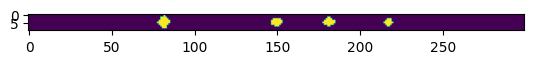

In [38]:
# METHOD I
# 교수님께서 주신 방식을 사용하면 img file을 np.array() 로 받을 수 있겠죠?

img_name = 'train/image_0.png'
img = extract_img_zipfile(zip_path, img_name)
plt.imshow(img)

Time taken by extract_img_zipfile_opencv: 1.3648 seconds


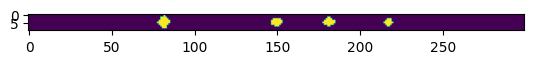

In [40]:
# METHOD II
# 조금 더 빠른 속도로 img를 읽어왔으나, 할 때마다 달라집니다.

img_name = 'train/image_0.png'
img = extract_img_zipfile_opencv(zip_path, img_name)
plt.imshow(img)

아래는 기존 코드

In [ ]:
class CustomizedDataset(Dataset):
    def __init__(self, data_dir, dataframe, transform = None):
        self.data_dir = data_dir # 데이터가 저장된 디렉토리를 불러옵니다.
        self.dataframe = dataframe # 데이터프레임 역시 가져옵니다.


        if transform == None:# transform이 없다면, transform을 torch.Tensor로 설정합니다.
            self.transform = torch.Tensor
        else:
            self.transform = transform

    def __len__(self): # 데이터프레임 개수를 불러와서 개수 뽑아내기.
        return len(self.dataframe) # train의 경우 60000개가 나와야겠죠?

    def __getitem__(self, idx):
        img_path = self.dataframe['img_path'][idx] # index에 해당하는 img_path를 불러온다.
        img = Image.open(self.data_dir + img_path) # path에 해당하는 이미지를 불러온다.
        img = np.array(img) # 이미지를 numpy array로 변환한다.

        n, potential = self.dataframe['n'][idx], self.dataframe['potential'][idx] # index에 해당하는 n, potential을 불러온다.
        transformed_img = self.transform(img) # 이미지를 transform한다.
        transformed_label = self.transform([n, potential]) # label을 transform한다.
        #image, Label의 dtype이 torch.Tensor여야하므로 위의 변환이 진행되었습니다.
        return transformed_img, transformed_label

## 교수님 코드와 함께 수정된 version

이미지를 가져오는 방식이 PIL Image 모듈을 사용하는 방식에서 바뀌었으니 dataset class도 수정해줘야 합니다.

다른 부분은 모두 그대로이나, 교수님께서 주신 두 방식중 어떤 것을 사용할 지 지정하는 method_1 = True 가 추가되었고, 이에 따라 이미지를 가져오는 부분만 변경되었습니다.

In [42]:
class CustomizedDataset(Dataset):
    def __init__(self, zip_path, dataframe, method_1 = True, transform = None):
        self.zip_path = zip_path #zip_path 정보를 불러옵니다. data_dir 그대로 쓰셔도 되나, 이해를 위해 이름을 수정하였습니다.
        self.dataframe = dataframe
        self.method_1 = method_1 #교수님이 주신 두 방식 중 선택하는 Flag 인자입니다.

        if transform == None:
            self.transform = torch.Tensor
        else:
            self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe['img_path'][idx] # index에 해당하는 img_path를 불러온다.
        if self.method_1 == True:
          img = extract_img_zipfile(self.zip_path, img_name) #img 불러오는 부분을 교수님 함수1로 변경합니다.
        else:
          img = img = extract_img_zipfile_opencv(self.zip_path, img_name) #img 불러오는 부분을 교수님 함수2로 변경합니다.

        n, potential = self.dataframe['n'][idx], self.dataframe['potential'][idx]
        transformed_img = self.transform(img)
        transformed_label = self.transform([n, potential])
        return transformed_img, transformed_label

In [45]:
train_dataset_1 = CustomizedDataset(zip_path, train, method_1 = True)  #method 1 사용
valid_dataset_1 = CustomizedDataset(zip_path, valid, method_1 = True)

train_dataset_2 = CustomizedDataset(zip_path, train, method_1 = False)  #method 2 사용
valid_dataset_2 = CustomizedDataset(zip_path, valid, method_1 = False)
train_dataset_1[0]

Time taken by extract_img_zipfile: 1.3697 seconds


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([6.0000, 0.4570]))

Time taken by extract_img_zipfile: 2.3417 seconds


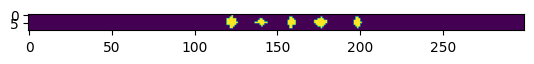

In [48]:
plt.imshow(train_dataset_1[0][0])

Time taken by extract_img_zipfile_opencv: 1.0990 seconds


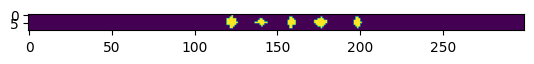

In [49]:
plt.imshow(train_dataset_2[0][0])

In [58]:
train_loader_1 = DataLoader(train_dataset_1, batch_size = 16, shuffle = True)
valid_loader_1 = DataLoader(valid_dataset_1, batch_size = 16, shuffle = False)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 16, shuffle = True)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size = 16, shuffle = False)

## Method 1과 2 Loading 시간 비교

In [59]:
#METHOD 1
start_time = time.time()
img, lab = next(iter(train_loader_1))
end_time = time.time()
print("경과된 시간", end_time - start_time)

Time taken by extract_img_zipfile: 1.4161 seconds
Time taken by extract_img_zipfile: 2.3372 seconds
Time taken by extract_img_zipfile: 2.2940 seconds
Time taken by extract_img_zipfile: 1.0840 seconds
Time taken by extract_img_zipfile: 1.6496 seconds
Time taken by extract_img_zipfile: 1.3292 seconds
Time taken by extract_img_zipfile: 1.3182 seconds
Time taken by extract_img_zipfile: 1.3487 seconds
Time taken by extract_img_zipfile: 1.3419 seconds
Time taken by extract_img_zipfile: 1.0676 seconds
Time taken by extract_img_zipfile: 1.9102 seconds
Time taken by extract_img_zipfile: 2.2982 seconds
Time taken by extract_img_zipfile: 1.6641 seconds
Time taken by extract_img_zipfile: 1.3392 seconds
Time taken by extract_img_zipfile: 1.3546 seconds
Time taken by extract_img_zipfile: 1.0954 seconds
경과된 시간 24.871365070343018


In [60]:
#METHOD 2
start_time = time.time()
img, lab = next(iter(train_loader_2))
end_time = time.time()
print("경과된 시간", end_time - start_time)

Time taken by extract_img_zipfile_opencv: 1.3275 seconds
Time taken by extract_img_zipfile_opencv: 1.3442 seconds
Time taken by extract_img_zipfile_opencv: 1.3527 seconds
Time taken by extract_img_zipfile_opencv: 1.3923 seconds
Time taken by extract_img_zipfile_opencv: 1.9618 seconds
Time taken by extract_img_zipfile_opencv: 2.2389 seconds
Time taken by extract_img_zipfile_opencv: 1.3210 seconds
Time taken by extract_img_zipfile_opencv: 1.2745 seconds
Time taken by extract_img_zipfile_opencv: 1.2866 seconds
Time taken by extract_img_zipfile_opencv: 1.3237 seconds
Time taken by extract_img_zipfile_opencv: 1.5217 seconds
Time taken by extract_img_zipfile_opencv: 1.0543 seconds
Time taken by extract_img_zipfile_opencv: 1.3216 seconds
Time taken by extract_img_zipfile_opencv: 1.6057 seconds
Time taken by extract_img_zipfile_opencv: 2.2940 seconds
Time taken by extract_img_zipfile_opencv: 1.8843 seconds
경과된 시간 24.53080153465271


In [63]:
img.shape

torch.Size([16, 10, 300])

In [64]:
lab.shape

torch.Size([16, 2])